In [16]:
import sys
sys.path.append('../')
from PINN_Survey.problems.burgers.data.load import load_burgers_bounds
from PINN_Base.util import bounds_from_data, random_choice
from PINN_Survey.problems.burgers.v1 import Burgers, Burgers_Sphere_Net, Burgers_Soft_Mesh
from PINN_Survey.viz.loss_viz import viz_base, viz_2d_layer_norm, viz_mesh, viz_2d_svd, save_as_heightmap, viz_2d_row_norm, viz_2d_global_norm, make_contour_svd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
X_true,U_true,X_boundary,U_boundary, _ = load_burgers_bounds()

lower_bound,upper_bound = bounds_from_data(X_true)

X = np.vstack(X_boundary)
U = np.vstack(U_boundary)

X_df = random_choice(X_true)

Train a model to completion as per usual.

In [3]:
model_train = Burgers(0.01/np.pi, lower_bound,upper_bound, [2,20,20,20,20,20,20,1])
model_train.train_BFGS(X,U,X_df,True)






INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000006
  Number of iterations: 4602
  Number of functions evaluations: 4991


We need to evaluate the loss at many different weight values. Thus, we would like to be able to change the value of the variables. Although it is possible to directly reassign variables, it can be slow. Instead, we define a version of the base model which swaps all "Variable" tensorfs for "Placeholder" tensors. This allows us to feed the model new weights as an input to the model in an efficient manner. 

In [4]:
@viz_base
class Burgers_viz(Burgers):
    pass

Construct a parallel model using the viz-able class. This model should have the same input parameters as the original model.

In [6]:
model_viz = Burgers_viz(0.01/np.pi, lower_bound,upper_bound, [2,20,20,20,20,20,20,1])

Get the final weights of the model to expand around.

In [7]:
w0 = model_train.get_all_weights()

Now, we'll run the model on a gird of weight values to construct a 2d visualization

40000/40000 [==============================] - 500s 13ms/step


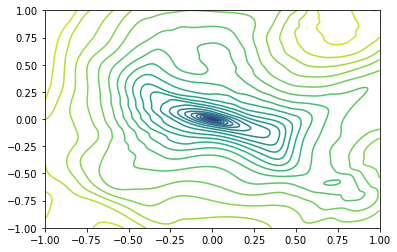

In [8]:
t1,t2,values = viz_2d_layer_norm(model_viz, X,U,X_df,w0,n=200)

plt.contour(t1,t2,np.log(values), levels=30)

We can visualize other properties of the model by using the "metrics" parameter in viz_2d funtions. This allows us, for instance, to visualizae the boundary and interior losses separately.

Text(0.5, 1.0, 'Loss Differential')

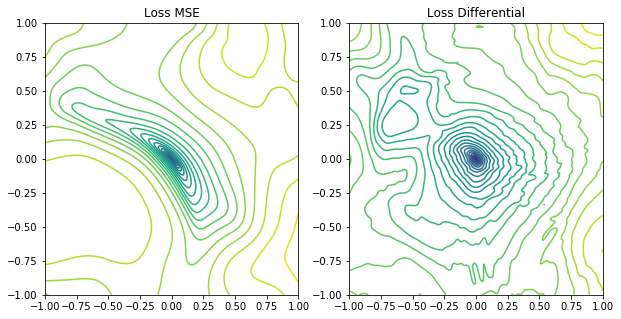

In [22]:
metrics = [model_viz.mse, model_viz.loss_residual_differential]

t1,t2,values = viz_2d_layer_norm(model_viz, X,U,X_df,w0,n=200, metrics=metrics)

fig,axes = plt.subplots(1,2,figsize=(10,5))

ax_mse = axes[0]
ax_mse.contour(t1,t2,np.log(values[0]),levels=30)
ax_mse.set_title("Loss MSE")

ax_diff = axes[1]
ax_diff.contour(t1,t2,np.log(values[1]),levels=30)
ax_diff.set_title("Loss Differential")

If we want to plot the path of the optimizer, we need to grab snapshots of the weights during training. So we'll create a new trainable model and then use the "fetches" parameter in train_BFGS to grab those. Note that we use "get_all_weight_variables()" rather than "get_all_weights()" since "get_all_weights()" returns a numpy array rather than a list of Varibale objects.

In [ ]:
model_train = Burgers(0.01/np.pi, lower_bound,upper_bound, [2,20,20,20,20,20,20,1])
fetches = [model_train.get_all_weight_variables()]
#False is important here. I didn't set it up to print the loss and fetch custom metrics.
epoch_weights = model_train.train_BFGS(X,U,X_df,False,custom_fetches=fetches)

w0 = model_train.get_all_weights()

#Wrapped in a list in case you wanted to fetch multiple things...
epoch_weights = [v[0] for v in epoch_weights]

t1,t2,loss, points,singular_values = viz_2d_svd(model_viz,X,U,X_df,w0, epoch_weights, n=200)

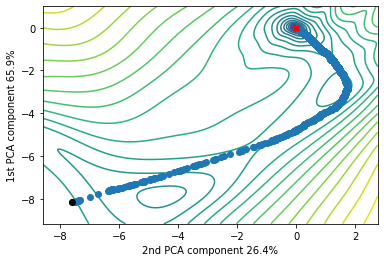

In [20]:
fig,ax = plt.subplots()
make_contour_svd(ax,t1,t2,loss, points, singular_values)